Data from [Tempo: an unsupervised Bayesian algorithm for circadian phase inference in single-cell transcriptomics](https://doi.org/10.1038/s41467-022-34185-w)

In [ ]:
import numpy as np
from CoPhaser import utils
from CoPhaser.trainer import Trainer
from CoPhaser.loss import Loss
from CoPhaser import plotting
from CoPhaser.model import CoPhaser
from CoPhaser.model import VAEModelLoader
from CoPhaser import gene_sets

import matplotlib.pyplot as plt
import seaborn as sns

import anndata
import scanpy as sc

import pandas as pd

DATA_FOLDER = "../../../data/"

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
adata = anndata.read_h5ad(f"{DATA_FOLDER}/aorta_circadian/adata_concatenated.h5ad")
adata

AnnData object with n_obs × n_vars = 22573 × 32285
    obs: 'batch', 'sample_id', 'sex', 'misaligned', 'zt', 'percent_mito', 'lib_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_qc_pass', 'umi_qc_pass', 'doublet_qc_pass', 'doublet_score', 'qc_pass', 'cluster', 'subcluster', 'log_L', 'phase', 'celltype'
    obsm: '2d_embedding', 'denoised_log_dispersion_hat', 'denoised_log_mean_hat', 'embedding'

In [7]:
adata.layers["total"] = adata.X.copy()

In [8]:
adata = adata[adata.obs["qc_pass"]].copy()

In [9]:
adata_remapped = anndata.read_h5ad(f"{DATA_FOLDER}/aorta_circadian/concatenated.h5ad")

In [10]:
adata_remapped.obs

,ZT,n_counts,sample_name,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,s_counts,u_counts,percent_unspliced,ZTmod,organ,celltype,celltype_organ
AAACCCACAGTGTGGA,0,15538.0,0,3632,15535.0,375.0,2.413904,14141.0,2465.0,0.148440,0,AORTA,Fibroblast,Fibroblast_AORTA
AAACCCACATGGTGGA,0,17729.0,0,3400,17726.0,1040.0,5.867088,15770.0,3658.0,0.188285,0,AORTA,Smc,Smc_AORTA
AAACCCAGTACAATAG,0,20667.0,0,4114,20663.0,1132.0,5.478391,18674.0,4035.0,0.177683,0,AORTA,Smc,Smc_AORTA
AAACCCAGTAGTGCGA,0,26627.0,0,4621,26627.0,983.0,3.691741,24245.0,3276.0,0.119036,0,AORTA,Smc,Smc_AORTA
AAACCCAGTGGTCTTA,0,17251.0,0,3794,17251.0,474.0,2.747667,15582.0,967.0,0.058433,0,AORTA,Smc,Smc_AORTA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTCACTAGT,18,14952.0,18,3600,14950.0,628.0,4.200669,13479.0,4473.0,0.249164,18,AORTA,Smc,Smc_AORTA
TTTGTTGGTGGCTACC,18,24879.0,18,4751,24877.0,722.0,2.902279,22404.0,5312.0,0.191658,18,AORTA,Smc,Smc_AORTA
TTTGTTGGTTCAGCTA,18,13359.0,18,3279,13358.0,165.0,1.235215,12078.0,2462.0,0.169326,18,AORTA,Fibroblast,Fibroblast_AORTA
TTTGTTGGTTGCCGCA,18,27314.0,18,4616,27314.0,1296.0,4.744820,24715.0,5202.0,0.173881,18,AORTA,Smc,Smc_AORTA


<Axes: ylabel='Count'>

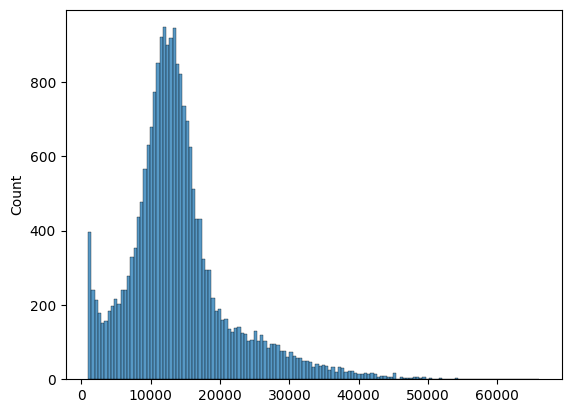

In [11]:
adata_all_genes = adata.copy()
layer_to_use = "total"
library_size = adata_all_genes.layers[layer_to_use].sum(axis=1).A1
sns.histplot(x=library_size)

In [12]:
# remove cells with less than 5000 counts
# adata = adata_all_genes[library_size >= 5000].copy()

In [13]:
# replace Arntl by Bmal1
var_names = adata.var_names.tolist()
var_names[var_names.index("Arntl")] = "Bmal1"
adata.var_names = var_names

In [14]:
SMALL_CYCLING_GENE_SET = gene_sets.SMALL_CIRCADIAN_GENE_SET

In [15]:
g = utils.get_variable_genes(adata, 2000)
len(g)

2000

In [16]:
genes_tempo = [
    "Arntl",
    "Arntl2",
    "Bhlhe41",
    "Ciart",
    "Clock",
    "Cry1",
    "Cry2",
    "Csnk1a1",
    "Csnk1d",
    "Csnk1e",
    "Dbp",
    "Dec1",
    "Dec2",
    "Fbxo21",
    "Fbxo3",
    "Gm129",
    "Hlf",
    "Nampt",
    "Nfil3",
    "Npas2",
    "Nr1d1",
    "Nr1d2",
    "Per1",
    "Per2",
    "Per3",
    "Rora",
    "Rorc",
    "Tef",
]

In [17]:
SMALL_CYCLING_GENE_SET = np.array(
    list(
        set(list(gene_sets.SMALL_CIRCADIAN_GENE_SET) + genes_tempo)
        & set(adata.var_names)
    )
)

In [18]:
len(SMALL_CYCLING_GENE_SET)

25

In [ ]:
pd.DataFrame(SMALL_CYCLING_GENE_SET, columns=["Gene"]).to_csv(
    "genes_tempo.csv", index=False
)

In [74]:
amp_phase_circadian = {
    "Bmal1": (1, 5.5),
    "Npas2": (0.5, 5.5),
    "Rorc": (0.5, 5.7),
    "Nr1d1": (1, 2.0),
    "Nr1d2": (0.75, 2.09),
    "Tef": (0.75, 2.35),
    "Ciart": (1, 2.35),
    "Dbp": (1, 2.09),
    "Per3": (1, 2.36),
    "Cry1": (0.5, 4.71),
    "Cry2": (0.25, 3),
    "Per2": (0.6, 3.14),
    "Per1": (0.5, 3.14),
    "Hlf": (0.5, 3.14),
}

In [75]:
SMALL_CYCLING_GENE_SET

array(['Hlf', 'Per1', 'Cry2', 'Csnk1a1', 'Cry1', 'Dbp', 'Nfil3', 'Tef',
       'Nr1d2', 'Fbxo21', 'Nr1d1', 'Csnk1d', 'Npas2', 'Rora', 'Rorc',
       'Nampt', 'Ciart', 'Per3', 'Per2', 'Clock', 'Bmal1', 'Arntl2',
       'Csnk1e', 'Bhlhe41', 'Fbxo3'], dtype='<U7')

In [ ]:
model = CoPhaser(
    SMALL_CYCLING_GENE_SET,
    g,
    n_latent=10,
    n_harm=1,
    rhythmic_decoder_to_all_genes=True,
    use_mu_z_encoder=True,
    use_amp_Z=True,
    z_range=20,
)
model.load_anndata(adata, layer_to_use="total")

VAEModelLoader.define_decoder_prior(amp_phase_prior=amp_phase_circadian, model=model)
# model.rhythmic_decoder.unfreeze_weights_harm([2])

Epoch 1/200, elbo_loss: 2486.6628, kl_div_f: 4.6776, kl_div_z: 29.9960, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -2.5752, entropy_loss: -128.7602, radial_variance: 0.0000, radius: 0.0000, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 2357.9025
Epoch 2/200, elbo_loss: 2062.0886, kl_div_f: 4.6230, kl_div_z: 39.4409, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.1521, entropy_loss: -157.6025, radial_variance: 0.0000, radius: 0.0000, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 1904.4881
Epoch 3/200, elbo_loss: 2008.6133, kl_div_f: 4.5658, kl_div_z: 39.7773, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.3295, entropy_loss: -166.4774, radial_variance: 0.0000, radius: 0.0000, L1_mu_z: 0.0000, MI_loss: 0.0003, total_loss: 1842.1489
Epoch 4/200, elbo_loss: 1972.0375, kl_div_f: 4.5023, kl_div_z: 39.3257, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.3892, en

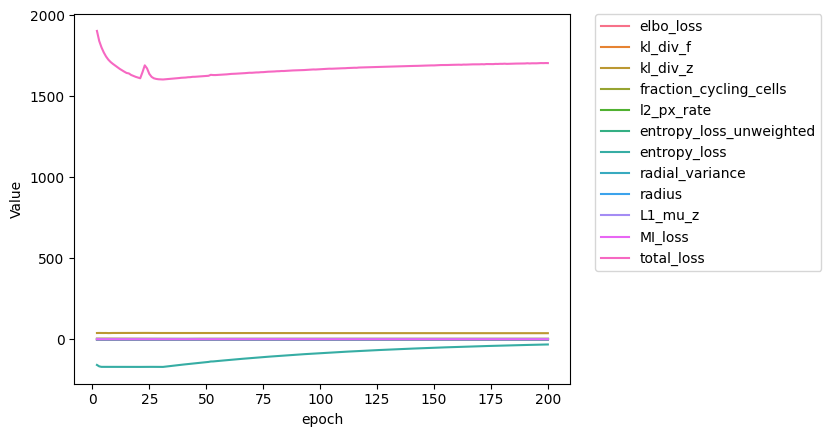

In [ ]:
trainer = Trainer(
    model,
    Loss.compute_loss,
    non_rhythmic_likelihood_weight=2,
    rhythmic_likelihood_weight=10,
    unfreeze_epoch_layer=[(10, "rhythmic_decoder")],
    L2_Z_decoder_loss_weight=0,
    closed_circle_weight=0,
    MI_weight=50,
    entropy_weight_factor=50,
    cycling_status_prior=1,
    MI_detach="f",
)
trainer.train_model(
    n_epochs=200,
    lr=1e-2,
    device="cuda",
    batch_size=2048,
)

<Axes: ylabel='Count'>

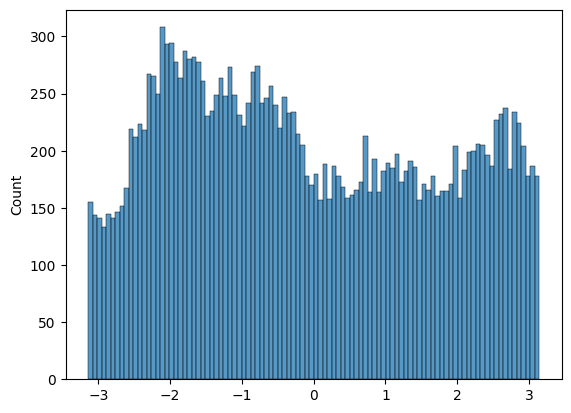

In [78]:
# Get the infered theta values
model.to("cpu")
generative_outputs, space_outputs = model.get_outputs()
# thetas = model.infer_pseudotimes(adata,"total",False)
thetas = np.arctan2(space_outputs["mu_theta"][:, 1], space_outputs["mu_theta"][:, 0])
sns.histplot(thetas, bins=100)

<Axes: xlabel='None', ylabel='Count'>

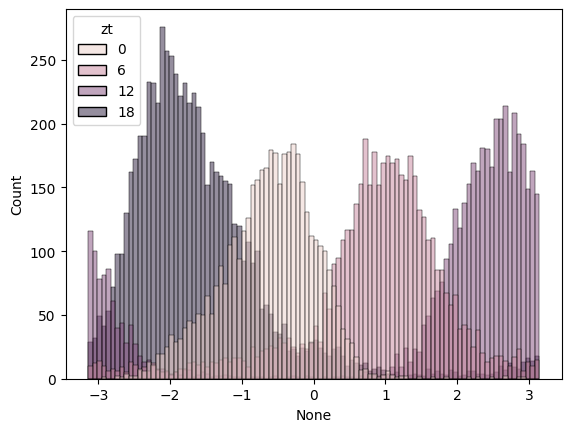

In [79]:
sns.histplot(x=thetas, bins=100, hue=adata.obs["zt"])

In [80]:
library_size = adata.layers["total"].sum(axis=1).A1

In [81]:
adata.obs["inferred_theta"] = thetas
adata.obs["library_size"] = library_size

In [82]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit


def fit_cosine_sine_model(
    adata,
    layer="total",
    phase_key="phase",
    n_harmonics=1,
    library_size_key="library_size",
):
    """
    Fit log-normalized cosine-sine model to each gene:
        log1p(expr / library_size * 1e4) ~ cos/sin harmonics

    Returns:
        DataFrame with mean expression, amplitude, and coefficients for each gene.
    """
    phases = adata.obs[phase_key].values.astype(float)
    X = adata.layers[layer]
    lib_size = adata.obs[library_size_key].values.astype(float)  # shape: (n_cells,)

    if not isinstance(X, np.ndarray):
        X = X.toarray()

    # Log-normalized expression
    log_norm_expr = np.log1p((X.T / lib_size * 1e4).T)  # broadcasting

    # Design matrix
    def design_matrix(phases, n_harmonics):
        return np.column_stack(
            [
                np.ones_like(phases),
                *[
                    func(k * phases)
                    for k in range(1, n_harmonics + 1)
                    for func in (np.cos, np.sin)
                ],
            ]
        )

    D = design_matrix(phases, n_harmonics)
    coefs = np.linalg.lstsq(D, log_norm_expr, rcond=None)[0]  # shape: (2n+1, n_genes)

    means = coefs[0]
    amplitudes = np.sqrt(np.sum(coefs[1:] ** 2, axis=0))

    columns = ["mean_expression", "amplitude"] + [
        f"{fn}_{k}" for k in range(1, n_harmonics + 1) for fn in ("cos", "sin")
    ]
    data = np.vstack([means, amplitudes, coefs[1:]]).T
    return pd.DataFrame(data, index=adata.var_names, columns=columns)


def filter_genes_by_mean_amplitude(df, mean_thresh=None, amp_thresh=None, top_n=None):
    """
    Filter the genes based on high mean expression and high oscillation amplitude.

    Args:
        df: Output DataFrame from `fit_cosine_sine_model`.
        mean_thresh: Minimum mean expression to retain.
        amp_thresh: Minimum amplitude to retain.
        top_n: If set, keeps only top_n genes sorted by amplitude.

    Returns:
        Filtered DataFrame.
    """
    df_filtered = df.copy()

    if mean_thresh is not None:
        df_filtered = df_filtered[df_filtered["mean_expression"] >= mean_thresh]
    if amp_thresh is not None:
        df_filtered = df_filtered[df_filtered["amplitude"] >= amp_thresh]
    if top_n is not None:
        df_filtered = df_filtered.sort_values(by="amplitude", ascending=False).head(
            top_n
        )

    return df_filtered


fit_results = fit_cosine_sine_model(
    adata, layer="total", phase_key="inferred_theta", n_harmonics=1
)
filtered_genes = filter_genes_by_mean_amplitude(
    fit_results, mean_thresh=0.1, amp_thresh=0.5
)
print(filtered_genes.head())

       mean_expression  amplitude     cos_1     sin_1
Eln           2.633557   0.508661  0.508596 -0.008166
Dbp           0.606975   0.790792 -0.443030  0.655040
Tcap          0.932041   0.597608 -0.310698  0.510492
Nr1d1         0.355377   0.503836  0.152078  0.480336


In [83]:
filtered_genes = filter_genes_by_mean_amplitude(
    fit_results, mean_thresh=0.01, amp_thresh=0.4
)
filtered_genes.head(20)

,mean_expression,amplitude,cos_1,sin_1
Eln,2.633557,0.508661,0.508596,-0.008166
Dbp,0.606975,0.790792,-0.443030,0.655040
Tcap,0.932041,0.597608,-0.310698,0.510492
Nr1d1,0.355377,0.503836,0.152078,0.480336
Fos,2.165395,0.404665,0.346075,0.209728


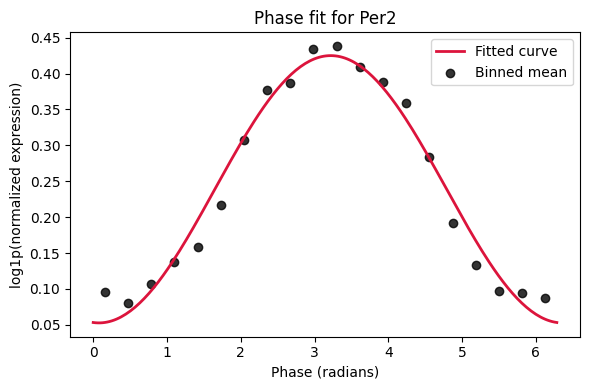

In [84]:
import matplotlib.pyplot as plt


def plot_phase_fit(
    adata,
    gene,
    fit_df,
    layer="total",
    phase_key="inferred_theta",
    n_harmonics=1,
    library_size_key="library_size",
    n_bins=20,
    n_points=200,
):
    """
    Plot binned mean log-normalized expression and fitted harmonic curve.
    """
    if gene not in adata.var_names:
        raise ValueError(f"Gene '{gene}' not found in adata.var_names.")

    idx = list(adata.var_names).index(gene)
    phases = adata.obs[phase_key].values.astype(float) % (2 * np.pi)
    lib_size = adata.obs[library_size_key].values.astype(float)
    expr = adata.layers[layer][:, idx]
    if not isinstance(expr, np.ndarray):
        expr = expr.toarray().flatten()

    # Log-normalized expression
    log_expr = np.log1p(expr / lib_size * 1e4)

    # Bin phases
    bin_edges = np.linspace(0, 2 * np.pi, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    digitized = np.digitize(phases, bin_edges) - 1
    digitized = np.clip(digitized, 0, n_bins - 1)

    binned_means = np.array(
        [
            log_expr[digitized == i].mean() if np.any(digitized == i) else np.nan
            for i in range(n_bins)
        ]
    )

    # Fitted curve
    phase_grid = np.linspace(0, 2 * np.pi, n_points)
    coefs = [fit_df.loc[gene, "mean_expression"]]
    for k in range(1, n_harmonics + 1):
        coefs.append(fit_df.loc[gene, f"cos_{k}"])
        coefs.append(fit_df.loc[gene, f"sin_{k}"])

    fit_values = coefs[0] + sum(
        coefs[2 * k - 1] * np.cos(k * phase_grid)
        + coefs[2 * k] * np.sin(k * phase_grid)
        for k in range(1, n_harmonics + 1)
    )

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(phase_grid, fit_values, color="crimson", label="Fitted curve", linewidth=2)
    plt.scatter(
        bin_centers, binned_means, label="Binned mean", color="black", alpha=0.8
    )
    plt.xlabel("Phase (radians)")
    plt.ylabel("log1p(normalized expression)")
    plt.title(f"Phase fit for {gene}")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Plot fit for a gene
# plot_phase_fit(adata, gene="Sparc", fit_df=fit_results, n_harmonics=1)
plot_phase_fit(adata, gene="Per2", fit_df=fit_results, n_harmonics=1)

In [85]:
def add_theta(df, theta):
    df["inferred_theta"] = theta
    return df


df_mean = pd.DataFrame(
    generative_outputs["px_rate"].detach().numpy(), columns=model.context_genes
)
df_mean = add_theta(df_mean, thetas)
df_rhythmic = pd.DataFrame(
    generative_outputs["F"].detach().numpy(), columns=model.context_genes
)
# df_rhythmic = pd.DataFrame(generative_outputs["rhythmic_term"].detach().numpy(), columns=model.context_genes)
df_rhythmic = add_theta(df_rhythmic, thetas)
df_z = pd.DataFrame(
    generative_outputs["Z"].detach().numpy(), columns=model.context_genes
)
df_z = add_theta(df_z, thetas)

In [86]:
adata.var_names[adata.var_names.str.startswith("Arn")]

Index(['Arnt', 'Arntl2', 'Arnt2'], dtype='object')

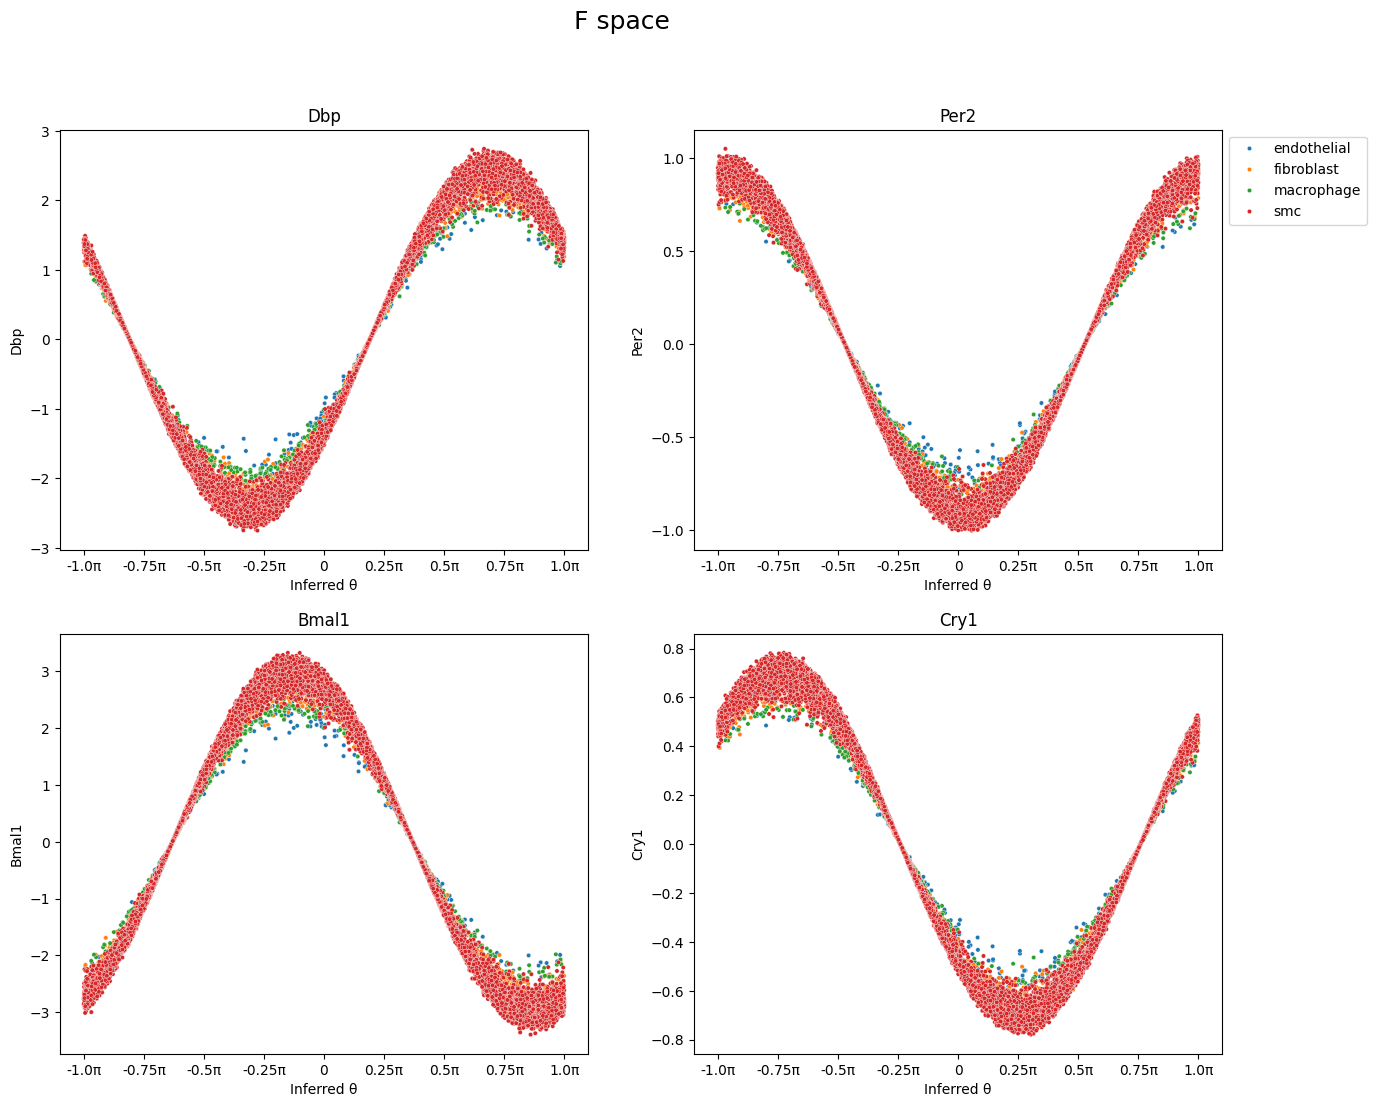

In [87]:
genes = ["Dbp", "Per2", "Bmal1", "Cry1"]
plotting.plot_model_decoded_space(
    df_rhythmic,
    gene_to_upper=False,
    title="F space",
    genes=genes,
    hue=adata.obs["celltype"].values,
)

In [88]:
adata.obs

,batch,sample_id,sex,misaligned,zt,percent_mito,lib_size,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,...,doublet_qc_pass,doublet_score,qc_pass,cluster,subcluster,log_L,phase,celltype,inferred_theta,library_size
index,,,,,,,,,,,,,,,,,,,,,
ACACTGACATTGCCTC-1,2,99991,male,False,6,0.014265,10445.0,2510,7.828436,10445.0,...,True,0.13895216400911162,True,2,10,9.253879,1.570796,endothelial,-0.222082,10445.0
ACTTAGGGTAGACAGC-1,2,99991,male,False,6,0.054101,18299.0,4611,8.436417,18299.0,...,True,0.13895216400911162,True,2,10,9.814602,1.570796,endothelial,1.492441,18299.0
AGAGCAGTCTAACGCA-1,2,99991,male,False,6,0.032956,8830.0,2897,7.971776,8830.0,...,True,0.06524633821571238,True,2,10,9.085911,1.570796,endothelial,-0.416578,8830.0
AGTCATGTCCCGTGAG-1,2,99991,male,False,6,0.025398,8347.0,2540,7.840313,8347.0,...,True,0.06707317073170734,True,2,10,9.029657,1.570796,endothelial,0.528500,8347.0
AGTCTCCTCTAGTTCT-1,2,99991,male,False,6,0.029175,5827.0,2121,7.660114,5827.0,...,True,0.04994324631101023,True,2,10,8.670258,1.570796,endothelial,-0.443461,5827.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCATGAAAGT-1,11,99993,male,False,18,0.051208,10350.0,3023,8.014336,10350.0,...,True,0.16186252771618623,True,0,1,9.244741,4.712389,smc,-2.522316,10350.0
TTTGTTGGTCACTAGT-1-1,11,99993,male,False,18,0.042877,12081.0,3679,8.210668,12081.0,...,True,0.16186252771618623,True,0,2,9.399389,4.712389,smc,0.481720,12081.0
TTTGTTGGTGGCTACC-1,11,99993,male,False,18,0.032439,20161.0,4825,8.481773,20161.0,...,True,0.20375335120643442,True,0,3,9.911506,4.712389,smc,-1.268426,20161.0


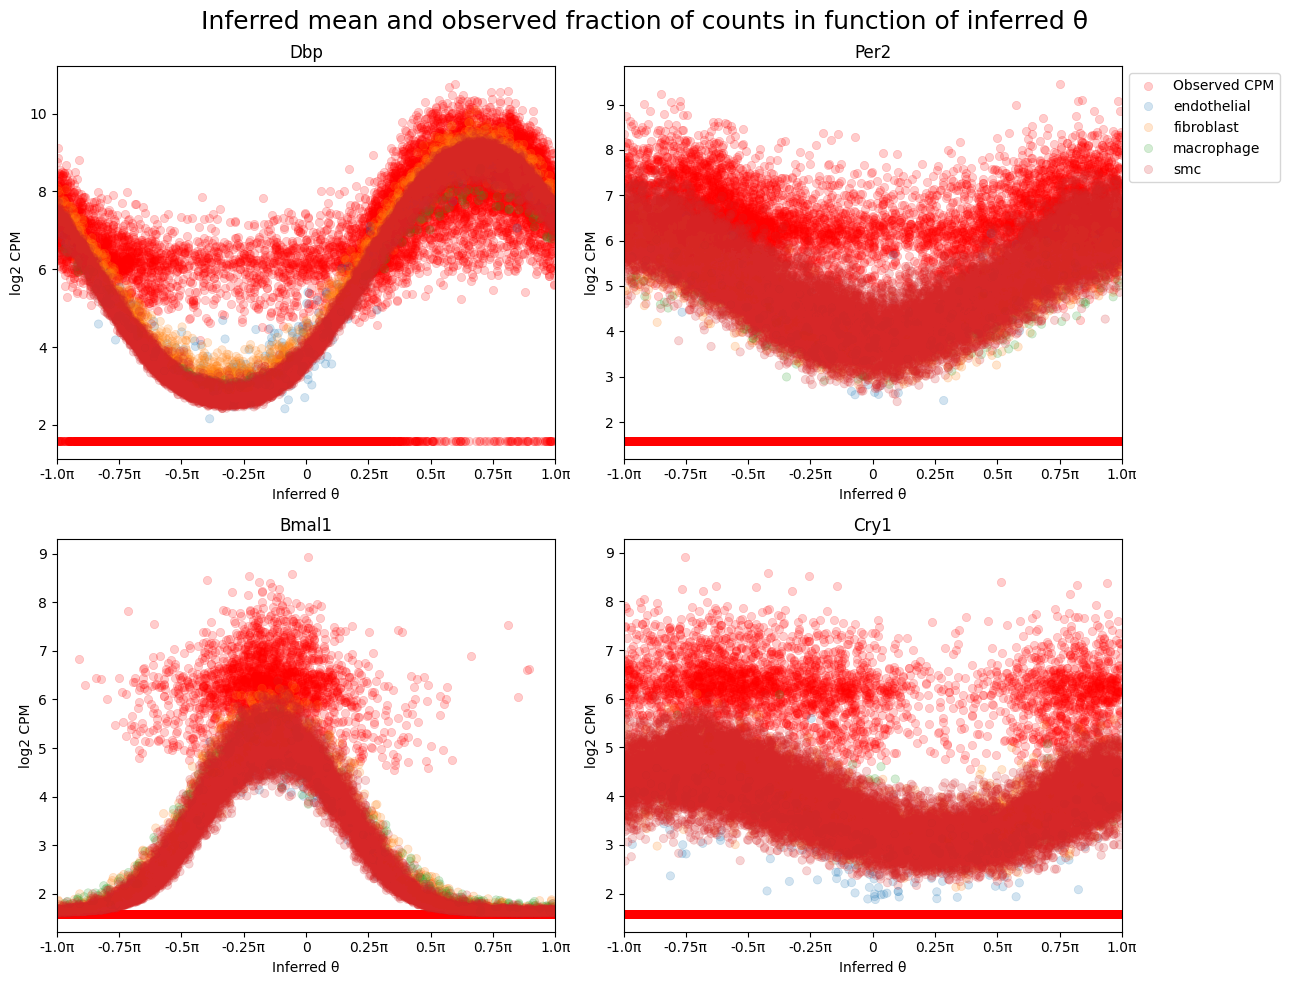

In [89]:
plotting.plot_gene_profile(
    df_mean,
    adata,
    genes,
    "total",
    2,
    False,
    library_size,
    hue=adata.obs["celltype"].values,
)

In [90]:
import umap

embedder = umap.UMAP(n_components=2, random_state=42)
embedding = embedder.fit_transform(space_outputs["z"].detach().numpy())

/home/maxine/miniconda3/envs/VAE_Fourrier_Env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/maxine/miniconda3/envs/VAE_Fourrier_Env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [91]:
def optimal_shift(p, p0, n_s=200):
    """
    Aligns two sequences defined on the unit circle, taking care of the periodicity
    and the flipping symmetry of the circle.
    It uses the median absolute deviation (MAD) as a measure of the distance between the two sequences.

    Parameters:
    p: phase array to adjust
    p0: phase array (reference)
    n_s: number of shifts to consider

    Returns:
    phi_aligned: the aligned phase array
    best_mad: the MAD of the best alignment
    """

    def circular_deviation2(x, y, period=2 * np.pi):
        """
        Function called by optimal_shift
        Inputs:
        x: phase array
        y: phase array
        period: period of the circular variable
        """
        x, y = x % period, y % period
        v1 = np.abs(x - y)
        v2 = (period - v1) % period

        return np.minimum(v1, v2)

    Nc = p.shape[0]
    shifts = np.linspace(0, 2 * np.pi, n_s)
    # creating a matrix of all possible shifts
    theta_cs = (p.reshape(Nc, 1) - shifts.reshape(1, n_s)) % (2 * np.pi)
    theta_cs_neg = (-p.reshape(Nc, 1) - shifts.reshape(1, n_s)) % (2 * np.pi)

    # for each shift, computing the circular deviation, using apply_along_axis
    delta_cs = circular_deviation2(p0[:, None], theta_cs)
    delta_cs_neg = circular_deviation2(p0[:, None], theta_cs_neg)

    # computing the median absolute deviation for all shifts
    v = np.median(delta_cs, axis=0)
    v_neg = np.median(delta_cs_neg, axis=0)
    # selecting the best shift
    best_shift_ind = np.argmin(v)
    best_shift_ind_neg = np.argmin(v_neg)
    mad, mad_neg = v[best_shift_ind], v_neg[best_shift_ind_neg]

    # selecting which direction is the best
    if mad < mad_neg:
        phi_aligned = theta_cs[:, best_shift_ind]
        best_mad = mad
    else:
        phi_aligned = theta_cs_neg[:, best_shift_ind_neg]
        best_mad = mad_neg

    return phi_aligned, best_mad


def get_MAD(adata, thetas):
    w = 2 * np.pi / 24
    true_phase = (adata.obs.zt.values % 24) * w
    if not isinstance(thetas, np.ndarray):
        thetas = thetas.detach().numpy()
    phi = thetas % (2 * np.pi)

    _, mad = optimal_shift(phi, true_phase)
    return mad / w


get_MAD(adata, thetas)

1.7000509482299089

In [92]:
thetas

tensor([-0.2221,  1.4924, -0.4166,  ..., -1.2684, -2.1203,  0.1946])

<Axes: >

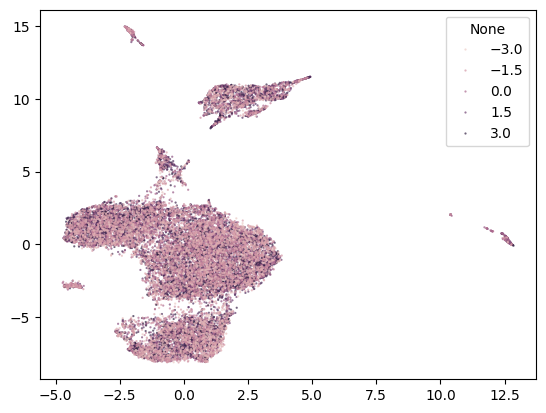

In [93]:
sns.scatterplot(
    x=embedding[:, 0], y=embedding[:, 1], hue=thetas, alpha=0.7, edgecolor=None, s=2
)

In [ ]:
delta_mu = generative_outputs["Z"][:, model.context_genes.index("Dbp")].detach().numpy()

In [95]:
delta_mu = generative_outputs["lambda"].detach().numpy().flatten()

In [96]:
delta_mu.shape

(20727,)

In [97]:
delta_mu

array([1.1331196 , 0.98926216, 0.87722343, ..., 1.0710064 , 1.0267129 ,
       1.0745856 ], dtype=float32)

<Axes: >

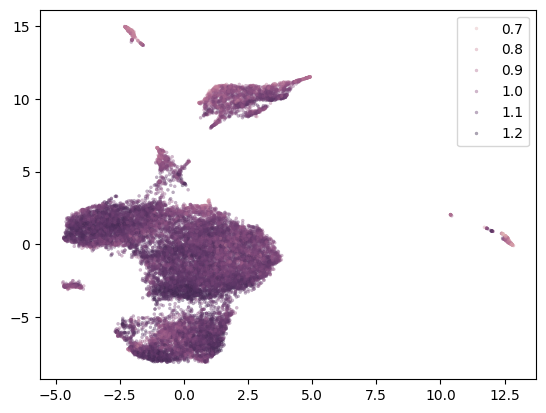

In [98]:
sns.scatterplot(
    x=embedding[:, 0], y=embedding[:, 1], hue=delta_mu, alpha=0.4, edgecolor=None, s=5
)

In [99]:
# leiden clustering on the embeddings
import scanpy as sc

adata.obsm["X_umap"] = embedding
sc.pp.neighbors(adata, use_rep="X_umap")
sc.tl.leiden(adata, resolution=0.01)

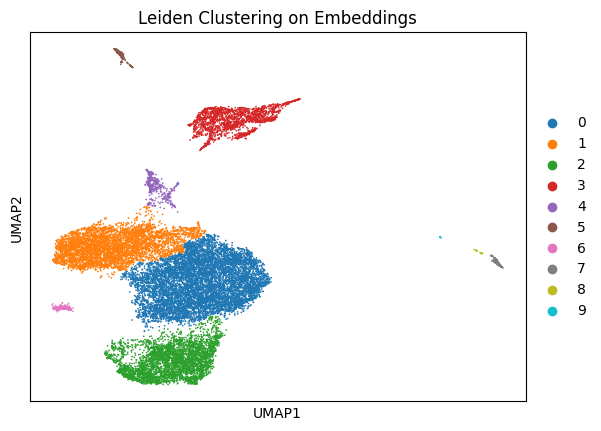

In [100]:
# visualize clusters
sc.pl.umap(adata, color=["leiden"], title="Leiden Clustering on Embeddings")

In [101]:
adata.obs

,batch,sample_id,sex,misaligned,zt,percent_mito,lib_size,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,...,doublet_score,qc_pass,cluster,subcluster,log_L,phase,celltype,inferred_theta,library_size,leiden
index,,,,,,,,,,,,,,,,,,,,,
ACACTGACATTGCCTC-1,2,99991,male,False,6,0.014265,10445.0,2510,7.828436,10445.0,...,0.13895216400911162,True,2,10,9.253879,1.570796,endothelial,-0.222082,10445.0,8
ACTTAGGGTAGACAGC-1,2,99991,male,False,6,0.054101,18299.0,4611,8.436417,18299.0,...,0.13895216400911162,True,2,10,9.814602,1.570796,endothelial,1.492441,18299.0,9
AGAGCAGTCTAACGCA-1,2,99991,male,False,6,0.032956,8830.0,2897,7.971776,8830.0,...,0.06524633821571238,True,2,10,9.085911,1.570796,endothelial,-0.416578,8830.0,7
AGTCATGTCCCGTGAG-1,2,99991,male,False,6,0.025398,8347.0,2540,7.840313,8347.0,...,0.06707317073170734,True,2,10,9.029657,1.570796,endothelial,0.528500,8347.0,7
AGTCTCCTCTAGTTCT-1,2,99991,male,False,6,0.029175,5827.0,2121,7.660114,5827.0,...,0.04994324631101023,True,2,10,8.670258,1.570796,endothelial,-0.443461,5827.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCATGAAAGT-1,11,99993,male,False,18,0.051208,10350.0,3023,8.014336,10350.0,...,0.16186252771618623,True,0,1,9.244741,4.712389,smc,-2.522316,10350.0,2
TTTGTTGGTCACTAGT-1-1,11,99993,male,False,18,0.042877,12081.0,3679,8.210668,12081.0,...,0.16186252771618623,True,0,2,9.399389,4.712389,smc,0.481720,12081.0,0
TTTGTTGGTGGCTACC-1,11,99993,male,False,18,0.032439,20161.0,4825,8.481773,20161.0,...,0.20375335120643442,True,0,3,9.911506,4.712389,smc,-1.268426,20161.0,0


In [102]:
2 ** (0.75 - 1)

0.8408964152537145

In [103]:
def get_gene_fractions(gene_name, adata, layer="total"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    gene_fractions = (
        adata[:, gene_name].layers[layer].toarray().flatten() / library_size
    )
    return gene_fractions


def get_genes_fractions(gene_names, adata, layer="total"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    gene_fractions = (adata[:, gene_names].layers[layer].toarray().T / library_size).T
    return gene_fractions


w = 2 * np.pi / 24
true_phase = (adata.obs.zt.values % 24) * w
phi = adata.obs.inferred_theta.values % (2 * np.pi)
adata.obs["Bmal1_fraction"] = get_gene_fractions("Dbp", adata, layer="total")
phase_aligned, mad = optimal_shift(phi, true_phase)

In [104]:
df_mean

,Wnt16,Nrp2,Tie1,Cd209f,Dnase1l3,Il1rl1,Igfbp2,Cpxm2,Slc13a3,Ahnak2,...,Lrrc15,Gata2,Lyve1,Emb,Flt3l,Gpm6b,Lrp1,Lrrc23,Tcf15,inferred_theta
0,0.011557,0.369355,0.000372,0.002893,5.444027e-02,0.620715,0.000604,0.000570,1.275134e-01,0.030037,...,6.444007e-08,0.001117,0.053845,1.650542,0.016304,0.016915,1.431535,1.624320e-08,0.001202,-0.222082
1,0.684396,1.468423,0.067525,0.014743,1.021591e-02,0.660924,9.338441,0.013601,6.423261e-04,3.804456,...,1.467538e-05,0.030549,2.688494,1.722524,0.121039,0.005736,3.356975,1.261003e-06,0.016286,1.492441
2,0.006593,0.736343,0.000057,0.191277,3.703917e-01,0.203099,0.002920,0.009094,2.504970e-01,0.018446,...,7.119981e-08,0.004470,1.588974,0.101615,0.044366,0.005201,1.491499,1.893753e-08,0.000056,-0.416578
3,0.006567,0.538807,0.000101,0.032225,4.278340e-01,0.256058,0.001657,0.002039,2.752889e-01,0.018917,...,5.177880e-08,0.002580,0.193573,0.407998,0.028580,0.003106,1.144312,7.017744e-09,0.000118,0.528500
4,0.006193,1.082944,0.000040,1.037773,6.071728e-02,0.166489,0.001550,0.003930,5.811546e-02,0.019456,...,6.245774e-08,0.001797,6.864590,0.080763,0.044906,0.002542,1.311987,1.513967e-08,0.000010,-0.443461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20722,1.339388,0.002198,0.000094,0.000335,3.533429e-07,0.000003,0.018352,0.002177,3.602892e-07,0.786874,...,4.177892e-06,0.000262,0.012206,0.659072,0.024369,0.006033,2.534685,1.684399e-07,0.000010,-2.522316
20723,0.919896,0.017303,0.000150,0.000410,2.204368e-05,0.000013,0.007516,0.008252,1.025371e-05,0.691099,...,2.306500e-04,0.001348,0.051781,1.141143,0.035275,0.006852,2.968570,6.661705e-08,0.000007,0.481720
20724,2.539229,0.016526,0.000440,0.000621,2.523342e-06,0.000005,0.158053,0.008812,9.717668e-07,3.118341,...,1.486793e-05,0.001230,0.028317,1.808681,0.050048,0.005867,5.033297,4.254738e-07,0.000020,-1.268426
20725,1.088053,0.015663,0.000689,0.000762,2.105181e-06,0.000013,0.048358,0.023593,2.142014e-06,2.043139,...,1.221204e-04,0.003295,0.026408,1.740277,0.056813,0.014545,5.027980,8.606371e-07,0.000178,-2.120306


In [105]:
clock_genes_fractions = get_genes_fractions(
    SMALL_CYCLING_GENE_SET, adata, layer="total"
)
# transform into dataframe
df_clock = pd.DataFrame(clock_genes_fractions, columns=SMALL_CYCLING_GENE_SET)
df_clock

,Hlf,Per1,Cry2,Csnk1a1,Cry1,Dbp,Nfil3,Tef,Nr1d2,Fbxo21,...,Nampt,Ciart,Per3,Per2,Clock,Bmal1,Arntl2,Csnk1e,Bhlhe41,Fbxo3
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000096,0.000000,0.000000
1,0.000000,0.000055,0.000000,0.000219,0.000000,0.000164,0.000000,0.000219,0.000109,0.000055,...,0.000109,0.0,0.000000,0.000000,0.000055,0.000000,0.000055,0.000055,0.000055,0.000055
2,0.000000,0.000340,0.000000,0.000227,0.000000,0.000000,0.000000,0.000000,0.000227,0.000113,...,0.000340,0.0,0.000000,0.000113,0.000113,0.000113,0.000000,0.000113,0.000000,0.000000
3,0.000000,0.000120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000120,0.000000,0.000120
4,0.000000,0.000000,0.000000,0.000172,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20722,0.000290,0.000000,0.000000,0.000097,0.000000,0.000000,0.000000,0.000000,0.000097,0.000000,...,0.000000,0.0,0.000000,0.000097,0.000097,0.000000,0.000000,0.000097,0.000000,0.000097
20723,0.000083,0.000000,0.000000,0.000662,0.000000,0.000000,0.000166,0.000083,0.000000,0.000000,...,0.000083,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20724,0.000000,0.000050,0.000000,0.000446,0.000000,0.000099,0.000099,0.000050,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000050,0.000000,0.000000,0.000000,0.000000,0.000000
20725,0.000044,0.000089,0.000044,0.000356,0.000044,0.000000,0.000267,0.000000,0.000000,0.000044,...,0.000133,0.0,0.000044,0.000089,0.000044,0.000000,0.000000,0.000044,0.000000,0.000044


In [108]:
from CoPhaser.model import interpretability

res = interpretability.compute_feature_importance(
    model,
    space_field=None,
    generative_field="Z",
    index_field=model.context_genes.index("Nampt"),
    mask_cells=adata.obs["leiden"].isin(["0", "2"]),
)

/home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/src/CoPhaser/model/interpretability.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_variable = x_variable[mask_cells]
/home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/src/CoPhaser/model/interpretability.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  library_size = library_size[mask_cells]


In [109]:
res.shape

(1, 2022)

In [110]:
pd.DataFrame(res.flatten(), model.context_genes).sort_values(0, ascending=False)

,0
Fbln1,0.918386
Dpt,0.904118
Col14a1,0.826465
Dbp,0.759700
Pcolce2,0.740722
...,...
Cytl1,-1.202484
Cfh,-1.373628
Gsn,-1.493324
Apoe,-1.493668


In [111]:
# find gene differentially expressed between cluster 0 and 1 in leiden
import scanpy as sc

sc.tl.rank_genes_groups(adata, groupby="leiden", groups=["2"], reference="0")
de_results = sc.get.rank_genes_groups_df(adata, group="2")
de_results

,names,scores,logfoldchanges,pvals,pvals_adj
0,Rgs5,64.564323,86.746490,0.0,0.0
1,Fn1,44.668064,37.238487,0.0,0.0
2,Fbln7,44.117023,4.659567,0.0,0.0
3,Hoxc10,44.053085,5.467791,0.0,0.0
4,Tmem176b,41.747135,4.354520,0.0,0.0
...,...,...,...,...,...
32280,Prelp,-59.305374,-5.788851,0.0,0.0
32281,Dsp,-59.372425,-5.359657,0.0,0.0
32282,Aqp1,-62.599247,-3.892580,0.0,0.0
32283,Fgl2,-64.093803,-7.046159,0.0,0.0


Total number of clusters found: 10

### 📉 3. Validating Smooth Muscle Cell (SMC) Identity ###
Assessing expression of canonical contractile markers across all clusters.


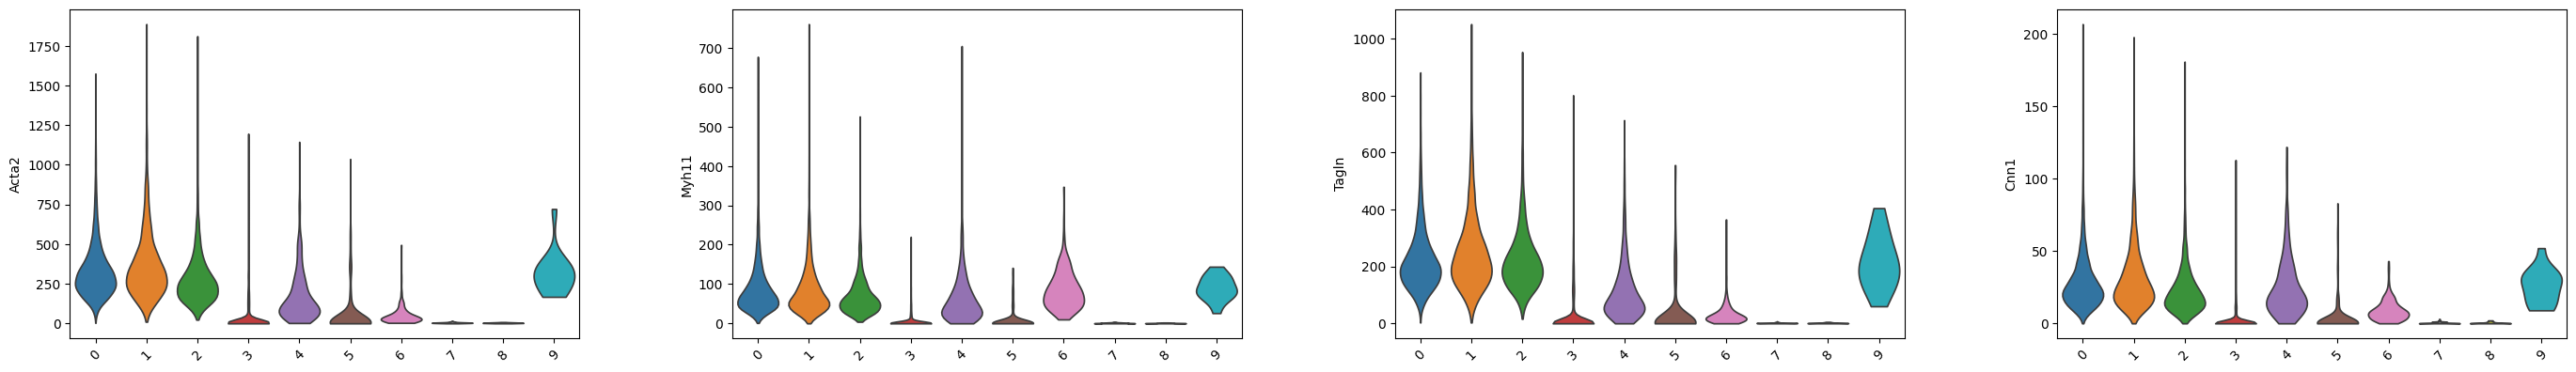

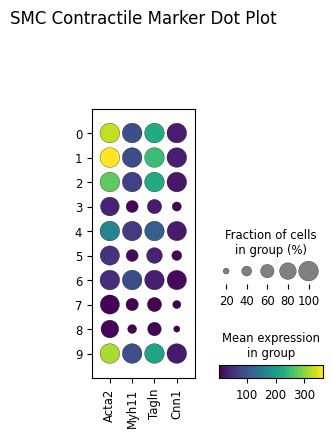


### 📈 4. Visualizing Specificity of DE Markers (Hox/Rgs5/Tnc) ###


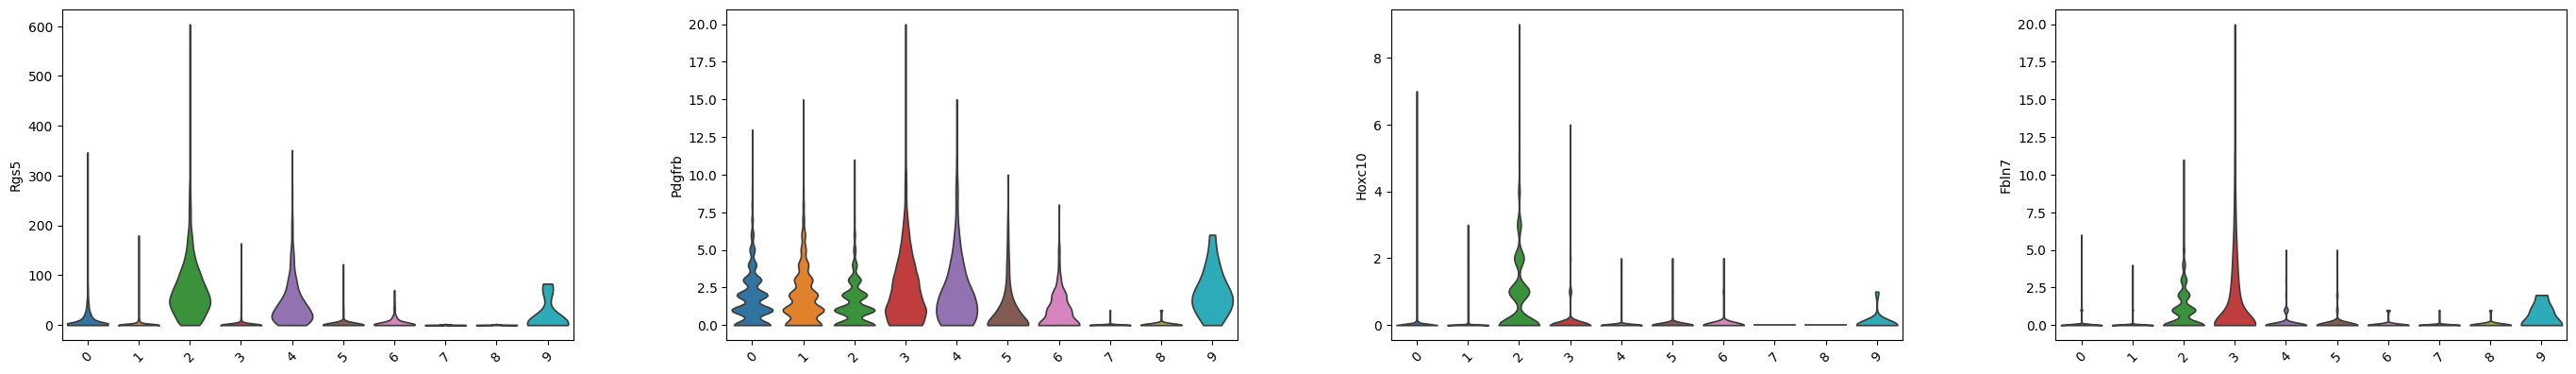

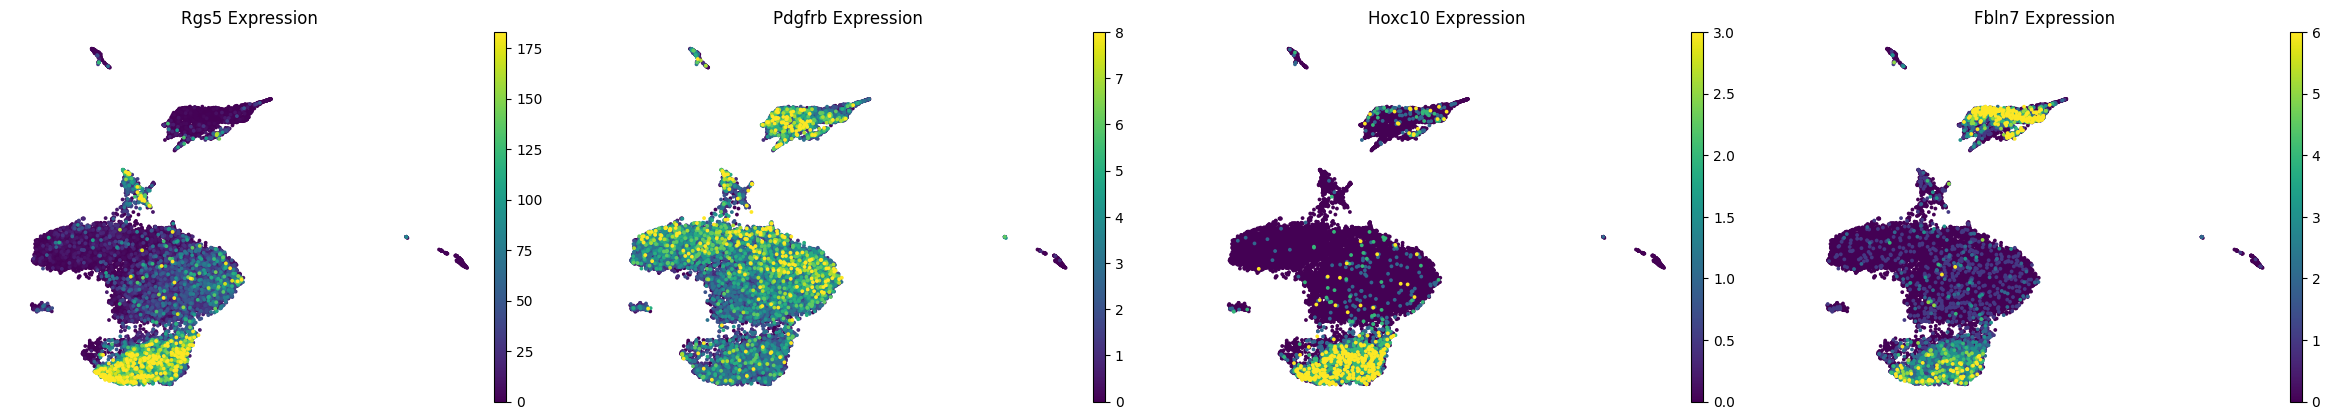

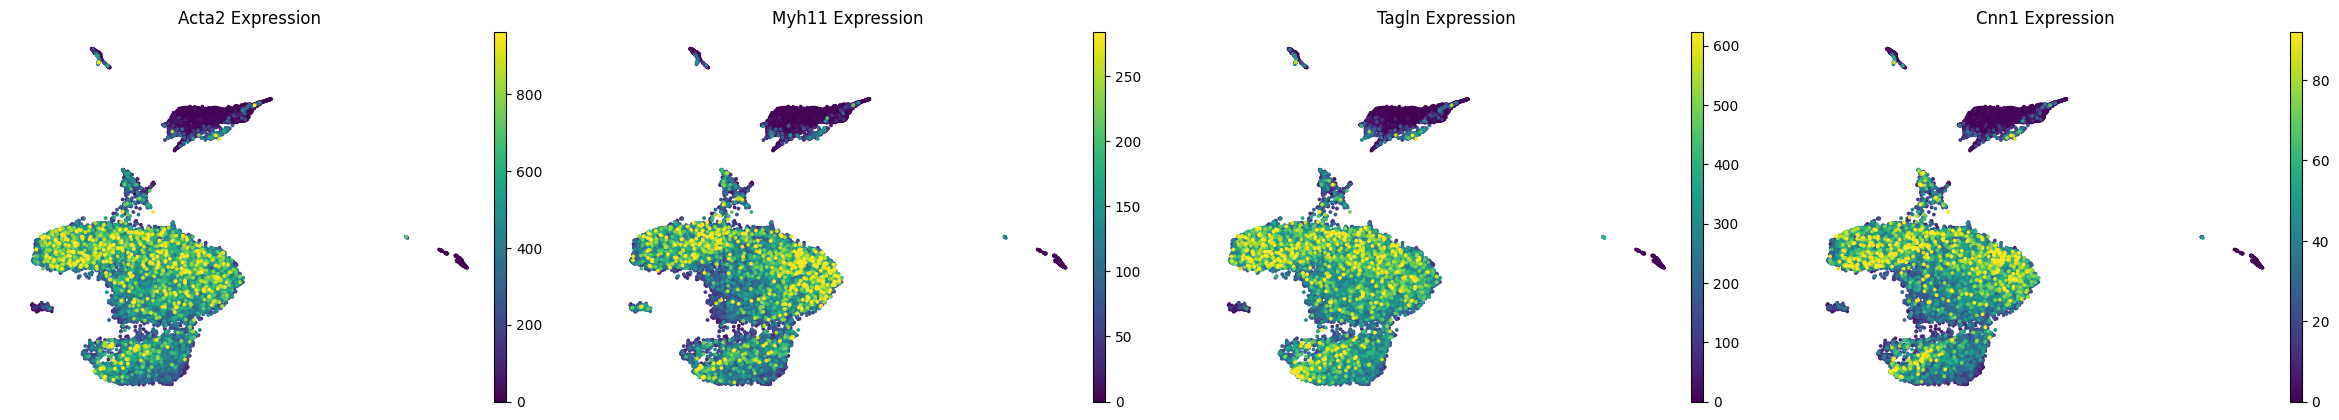


### 📊 5. Exporting Quantitative Data for Clusters 0 & 1 ###

--- Analysis Complete. Please review the generated plots and data file. ---


In [112]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. SETUP: ASSUME YOUR AnnData OBJECT 'adata' IS LOADED ---
# Example (uncomment if you need to load your data):
# try:
#     adata = sc.read_h5ad("your_processed_aorta_data.h5ad")
# except FileNotFoundError:
#     print("Error: AnnData file not found. Please ensure 'adata' is loaded.")
#     exit()

diff_cluster = "1"
main_cluster = "0"

# Ensure the 'leiden' clustering is available in obs
if "leiden" not in adata.obs.columns:
    print(
        "Error: 'leiden' column not found in adata.obs. Please check your clustering step."
    )
    exit()

print(f"Total number of clusters found: {adata.obs['leiden'].nunique()}")

# --- 2. DEFINE KEY MARKER GENES ---

# A. Canonical Contractile Smooth Muscle Cell (SMC) Markers
# Note: Lower expression of these in your subclusters suggests a 'synthetic' switch.
smc_markers = ["Acta2", "Myh11", "Tagln", "Cnn1"]

# B. Highly Differentially Expressed (DE) Genes from your list
de_markers = ["Rgs5", "Pdgfrb", "Hoxc10", "Fbln7"]


# --- 3. CHECK FOR SMC IDENTITY (Contractile Markers) ---

print("\n### 📉 3. Validating Smooth Muscle Cell (SMC) Identity ###")
print("Assessing expression of canonical contractile markers across all clusters.")

# A. Violin Plot for SMC Markers
sc.pl.violin(
    adata,
    keys=smc_markers,
    groupby="leiden",
    rotation=45,
    stripplot=False,  # Disable jitter plot for cleaner look
    show=True,
)

# B. Dot Plot for SMC Markers (Gives a quick summary of mean expression and percentage of expressing cells)
sc.pl.dotplot(
    adata,
    var_names=smc_markers,
    groupby="leiden",
    color_map="viridis",
    title="SMC Contractile Marker Dot Plot",
    show=True,
)

# INTERPRETATION FOR SMC CHECK:
# * If clusters 0 and 1 show high expression (similar to other SMC clusters) of these markers,
#   they are likely contractile SMCs with a specific regional/developmental signature (Hox).
# * If clusters 0 and 1 show significantly LOWER expression, it confirms the 'synthetic' or
#   'progenitor-like' phenotypic switch indicated by the DE genes.


# --- 4. VISUALIZE DE MARKERS SPECIFICITY (Hox and Rgs5) ---

print("\n### 📈 4. Visualizing Specificity of DE Markers (Hox/Rgs5/Tnc) ###")

# A. Violin Plot for the Specific DE Markers (Shows distribution of expression)
sc.pl.violin(
    adata,
    keys=de_markers,
    groupby="leiden",
    rotation=45,
    stripplot=False,
    show=True,
)

# B. Feature Plots (UMAP/tSNE) to see spatial localization
# Assuming 'umap' coordinates are computed and stored in adata.obsm['X_umap']
try:
    sc.pl.umap(
        adata,
        color=de_markers,
        size=30,
        vmax="p99",  # Cap max color intensity at 99th percentile for better contrast
        frameon=False,
        title=[f"{gene} Expression" for gene in de_markers],
        show=True,
    )
    # check SMC canonical markers as well
    sc.pl.umap(
        adata,
        color=smc_markers,
        size=30,
        vmax="p99",  # Cap max color intensity at 99th percentile for better contrast
        frameon=False,
        title=[f"{gene} Expression" for gene in smc_markers],
        show=True,
    )
except KeyError:
    print(
        "\nWarning: UMAP coordinates not found (X_umap missing). Skipping Feature Plot."
    )

# --- 5. DATA EXPORT (Optional: Quantitative comparison) ---

print("\n### 📊 5. Exporting Quantitative Data for Clusters 0 & 1 ###")

# Extract the mean expression of all markers for clusters 0 and 1
markers_to_check = smc_markers + de_markers
expression_means = sc.get.rank_genes_groups_df(adata, group=None)

print("\n--- Analysis Complete. Please review the generated plots and data file. ---")

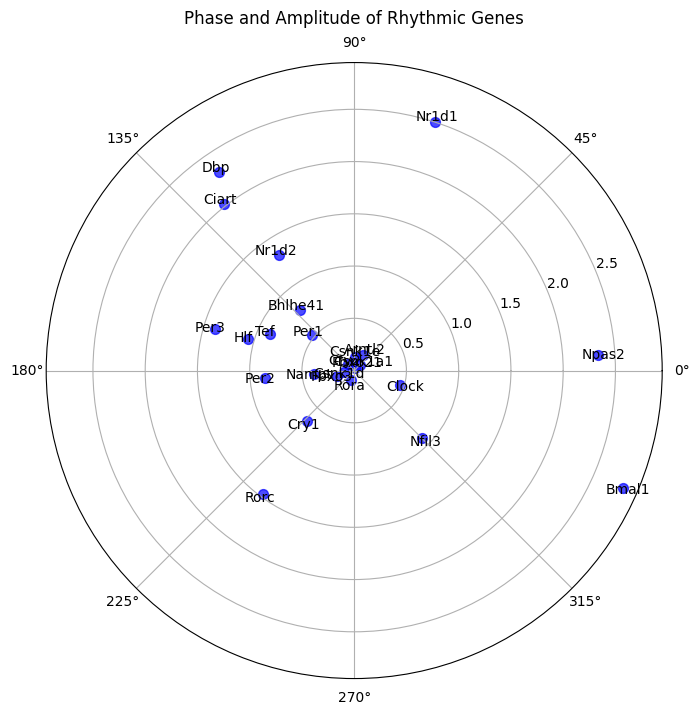

In [113]:
model.plot_fourier_coefficients()

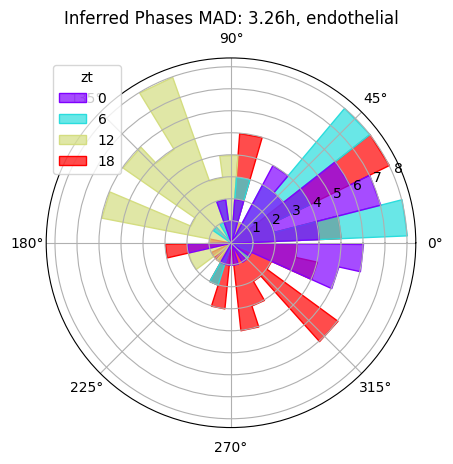

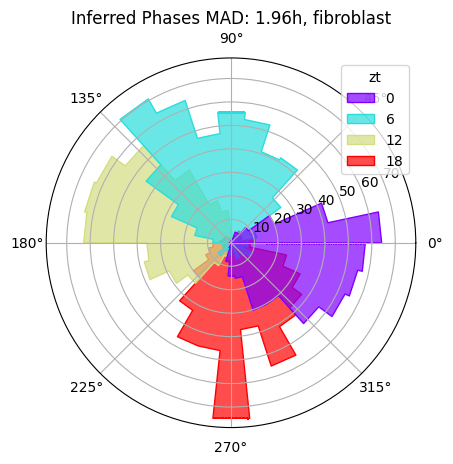

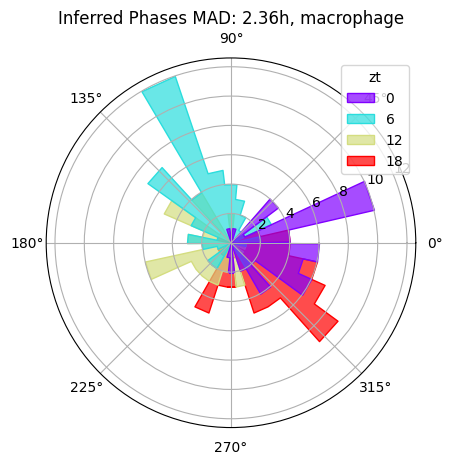

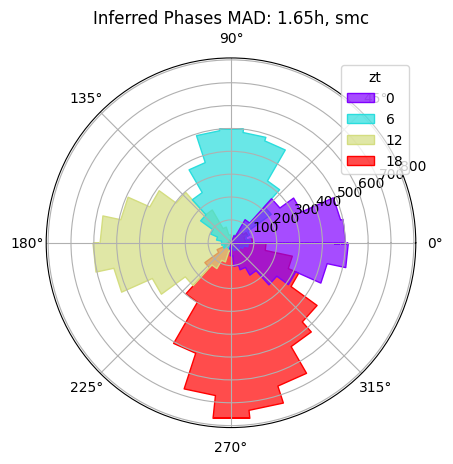

In [114]:
for ct in adata.obs["celltype"].unique().tolist():
    ax = plt.subplot(111, projection="polar")
    indices = adata.obs["celltype"] == ct
    sns.histplot(
        data=adata[indices].obs,
        x=phase_aligned[indices],
        hue="zt",
        element="step",
        palette="rainbow",
        ax=ax,
        fill=True,
        alpha=0.7,
        bins=30,
    )
    ax.set_title(
        f"Inferred Phases MAD: {get_MAD(adata[indices], phase_aligned[indices]):.2f}h, {ct}"
    )
    ax.set_ylabel("")
    plt.show()

In [116]:
# to_save = {}
# to_save["adata"] = adata
# to_save["phase_aligned"] = phase_aligned
# to_save["fourier_coefficients"] = (
#     model.rhythmic_decoder.fourier_coefficients.weight.detach().numpy()
# )
# to_save["lambda"] = generative_outputs["lambda"].detach().numpy()
# to_save["df_z"] = df_z
# to_save["df_rhythmic"] = df_rhythmic
# to_save["df_mean"] = df_mean
# to_save["z"] = embedding
# to_save["SMALL_CYCLING_GENE_SET"] = SMALL_CYCLING_GENE_SET
# to_save["variable_genes"] = model.context_genes
# to_save["rhythmic_gene_indices"] = model.rhythmic_gene_indices
# import pickle

# with open("data/aorta_results.pkl", "wb") as f:
#     pickle.dump(to_save, f)